<a href="https://colab.research.google.com/github/F-Abir/GEE-JS/blob/main/xee_temp_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

In [2]:
import geemap

In [3]:
!pip install xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00


In [4]:
import xee

In [5]:
import xarray as xr

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [9]:
import matplotlib.pyplot as plt

In [11]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-abirnahraf',
)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [12]:
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [14]:
roi = map.draw_last_feature.geometry()

In [15]:
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          450.240326,
                          23.569022
                        ],
                        [
                          450.240326,
                          24.055242
                        ],
                        [
                          450.578156,
                          24.055242
                        ],
                        [
                          450.578156,
                          23.569022
                        ],
                        [
                          450.240326,
                          23.569022
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [16]:
temp = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .filterDate('2001','2025')
    .select('LST_Day_1km')
    .map(lambda img: img.multiply(0.02).subtract(273.15).copyProperties(img, img.propertyNames()))
)

temp

In [17]:
xtemp = xr.open_dataset(
    temp,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.01,
    geometry = roi
)

xtemp


<xarray.Dataset> Size: 7MB
Dimensions:      (time: 1103, lon: 34, lat: 49)
Coordinates:
  * time         (time) datetime64[ns] 9kB 2001-01-01 2001-01-09 ... 2024-12-26
  * lon          (lon) float64 272B 90.25 90.26 90.27 ... 90.56 90.57 90.58
  * lat          (lat) float64 392B 23.57 23.58 23.59 23.6 ... 24.03 24.04 24.05
Data variables:
    LST_Day_1km  (time, lon, lat) float32 7MB ...
Attributes:
    crs:      EPSG:4326

In [18]:
xtemp_mean = xtemp.mean(dim  = ['lon', 'lat'])

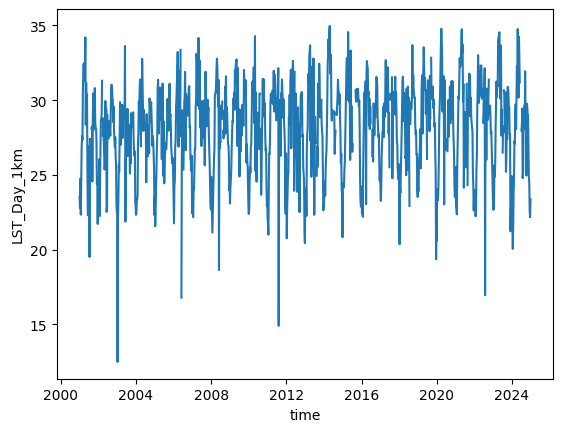

In [19]:
xtemp_mean.LST_Day_1km.plot()

In [20]:
xtemp_inte = xtemp_mean.interpolate_na(dim = 'time')

In [21]:
xtemp_df = xtemp_inte.to_dataframe()


In [22]:
xtemp_df.to_csv('temp_df.csv')


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose


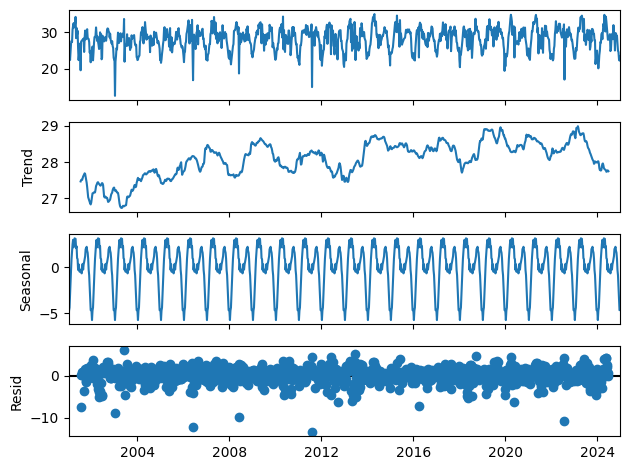

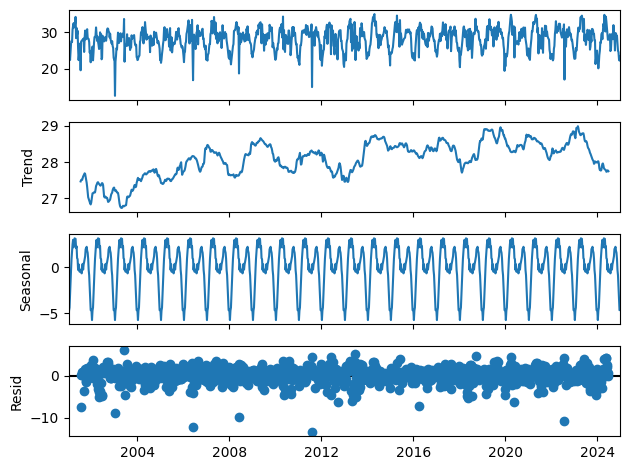

In [24]:
model = seasonal_decompose(
    xtemp_df,
    model = 'additive',
    period = 46
)

model.plot()


In [25]:
plt.show()

In [26]:
final_df = pd.DataFrame({
    'time': model.observed.index,
    'observations': model.observed.values,
    'trend': model.trend.values,
    'seasonal': model.seasonal.values,
    'residuals': model.resid.values
})

In [27]:
final_df = final_df.set_index('time')

<Axes: xlabel='time'>

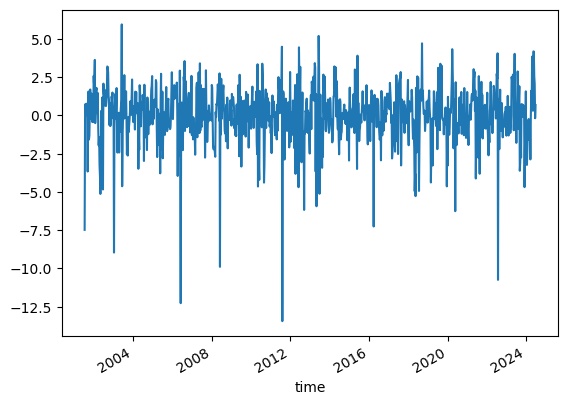

In [28]:
final_df.residuals.plot()

In [29]:
final_df.to_csv('temp_anomaly.csv')

In [30]:
pos = final_df[final_df['residuals'] >= 0]
neg = final_df[final_df['residuals'] < 0]

<BarContainer object of 488 artists>

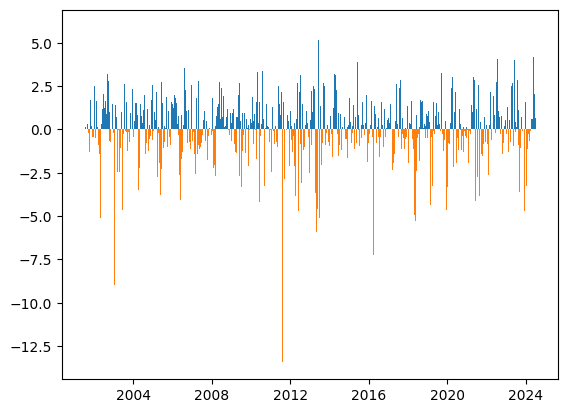

In [31]:
plt.bar(pos.index, pos.residuals, width = 10)
plt.bar(neg.index, neg.residuals, width = 10)